<a href="https://colab.research.google.com/github/xqwu1108-create/MSE1003H_XueqiuWu_1011808741/blob/main/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Introduction**

This project uses a dataset sourced from the Materials Project, consisting of 3000 inorganic material samples. To ensure data quality and relevance, materials were specifically selected within a bandgap range of 0.1 to 8.0 eV. The dataset includes various physical and chemical descriptors, such as formation energy, density, and atomic properties. The research objective is to develop and evaluate a machine learning pipeline to accurately predict the bandgap of materials, which incorporated dimensinality reduction and Random Forest regression.

# **2.Analysis**

# **2.1 Dataset Research and Loading**

The research question is to predict the bandgap of materials using a regression model based on chemical descriptors。

In [1]:
! pip install pymatgen
! pip install mp_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.3 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=724159372b4249b8a8d10cdc206dde64cdf91834f531563a3dad081b369c0b36
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
Successfully built bibtexparser
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
! pip install matminer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import userdata
from mp_api.client import MPRester
from pymatgen.core import Composition
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

In [4]:
# Fetch the secret named 'MP_API_KEY'
api_key = userdata.get('MP_API_KEY')

# Check for existence and valid length (32 chars for the new API)
if not api_key:
    print("Error: Could not find 'MP_API_KEY' in Secrets.")
elif len(api_key) != 32:
    print(f"Error: Key length is {len(api_key)}. The new API requires a 32-character key.")
else:
    print("Success: MP_API key retrieved from Secrets.")
# Reset the list INSIDE this cell
    material_data = []

    try:
        # Initialize the Materials Project requester with the environment key
        with MPRester(api_key) as mpr:
            # Search for materials based on specific physical constraints
            # Criteria: Bandgap 0.1-8.0 eV, containing 1 to 4 unique elements
            docs = mpr.materials.summary.search(
                band_gap=(0.1, 8.0),
                num_elements=(1, 4),
                fields=[
                    "material_id", "formula_pretty", "composition",
                    "band_gap", "formation_energy_per_atom", "density",
                    "volume", "nsites", "nelements"
                ]
            )

            print(f"Connection successful. Retrieved {len(docs)} matching entries.")

            # Processing the first 3000 entries for demonstration purposes
            for doc in docs[:3000]:
                material_data.append({
                    'material_id': doc.material_id,
                    'formula': doc.formula_pretty,
                    'composition': str(doc.composition),
                    'bandgap_eV': doc.band_gap,
                    'formation_energy': doc.formation_energy_per_atom,
                    'density_gcc': doc.density,
                    'volume_A3': doc.volume,
                    'n_atoms': doc.nsites,
                    'n_elements': doc.nelements
                })

        # Create structured DataFrame
        df = pd.DataFrame(material_data)

        print("\nData Loading Statistics:")
        print(f"Total entries processed: {len(df)}")
        if not df.empty:
            # Display stats using LaTeX notation in output strings for clarity
            print(f"Bandgap Range: {df['bandgap_eV'].min():.2f} eV to {df['bandgap_eV'].max():.2f} eV")
            print(f"Dataframe Shape: {df.shape}")

            print("\nHead of the processed dataset:")
            print(df.head())

    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Success: MP_API key retrieved from Secrets.


Retrieving SummaryDoc documents:   0%|          | 0/60551 [00:00<?, ?it/s]

Connection successful. Retrieved 60551 matching entries.

Data Loading Statistics:
Total entries processed: 3000
Bandgap Range: 0.10 eV to 7.94 eV
Dataframe Shape: (3000, 9)

Head of the processed dataset:
  material_id formula composition  bandgap_eV  formation_energy  density_gcc  \
0    mp-11107   Ac2O3      Ac2 O3      3.5226         -3.737668     9.109130   
1    mp-32800   Ac2S3    Ac16 S24      2.2962         -2.493064     6.535149   
2   mp-977351   Ac2S3      Ac4 S6      3.0275         -2.440364     5.562971   
3  mp-1183115  AcAlO3  Ac1 Al1 O3      4.1024         -3.690019     8.728230   
4  mp-1183052   AcBO3   Ac1 B1 O3      0.8071         -2.475390     9.206879   

     volume_A3  n_atoms  n_elements  
0    91.511224        5           2  
1  1118.407852       40           2  
2   328.464893       10           2  
3    57.451413        5           3  
4    51.548126        5           3  


# **2.2 Data Preprocessing and Exploratory Data Analysis**

In [6]:
# Randomly select 600 rows from the dataframe for the test partition
test_sample = df.sample(n=min(600, len(df)), random_state=1003)

print(f"Original dataframe size: {len(df)} rows")
print(f"Test partition size: {len(test_sample)} rows")
print(f"Percentage of data selected: {len(test_sample)/len(df)*100:.1f}%")

print(f"\nTest partition bandgap range: {test_sample['bandgap_eV'].min():.2f} - {test_sample['bandgap_eV'].max():.2f} eV")
print(f"Test partition shape: {test_sample.shape}")

# Remove test_sample from main dataframe
df_remaining = df.drop(test_sample.index)

print(f"\nRemaining dataframe size after removing test partition: {len(df_remaining)} rows")
print(f"Rows removed: {len(df) - len(df_remaining)} rows")
print(f"Remaining dataframe shape: {df_remaining.shape}")

# Ensure there's no intersection between sets to maintain evaluation integrity
assert len(set(df_remaining.index).intersection(set(test_sample.index))) == 0, "Overlap found!"
print("✔ Successfully removed test partition - no overlap detected")

# Reset index for clean downstream processing
train_df = df_remaining.reset_index(drop=True)
test_df = test_sample.reset_index(drop=True)

Original dataframe size: 3000 rows
Test partition size: 600 rows
Percentage of data selected: 20.0%

Test partition bandgap range: 0.10 - 7.56 eV
Test partition shape: (600, 9)

Remaining dataframe size after removing test partition: 2400 rows
Rows removed: 600 rows
Remaining dataframe shape: (2400, 9)
✔ Successfully removed test partition - no overlap detected


In [7]:
# Train Data preprocessing and EDA
print("Train Dataset Information:")
# Check data types, non-null counts, and memory usage
print(train_df.info())
print("\nSummary Statistics:")
# Display stats (mean, std, quartiles, etc.)
print(train_df.describe())
print("\nMissing values per column:")
# Count null values in each column
print(train_df.isnull().sum())

Train Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   material_id       2400 non-null   object 
 1   formula           2400 non-null   object 
 2   composition       2400 non-null   object 
 3   bandgap_eV        2400 non-null   float64
 4   formation_energy  2400 non-null   float64
 5   density_gcc       2400 non-null   float64
 6   volume_A3         2400 non-null   float64
 7   n_atoms           2400 non-null   int64  
 8   n_elements        2400 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 168.9+ KB
None

Summary Statistics:
        bandgap_eV  formation_energy  density_gcc     volume_A3      n_atoms  \
count  2400.000000       2400.000000  2400.000000   2400.000000  2400.000000   
mean      2.417513         -1.740026     4.319281    692.960477    39.350417   
std       1.688965  

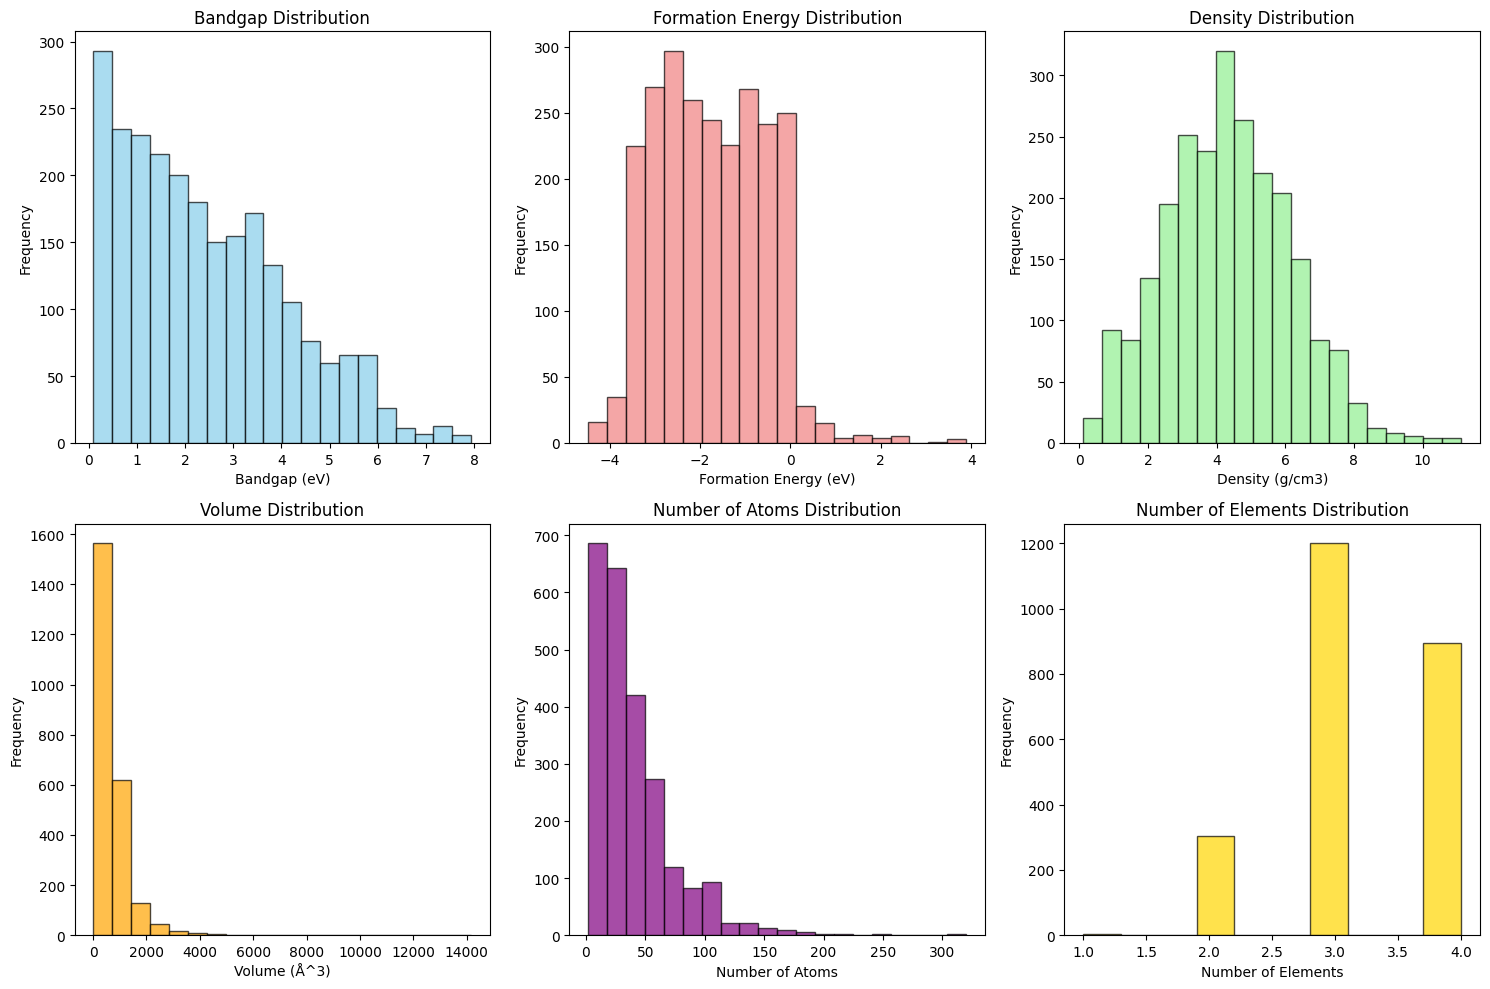

In [8]:
# Visualize Train Data Distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Bandgap distribution (target variable)
axes[0,0].hist(train_df['bandgap_eV'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Bandgap Distribution')
axes[0,0].set_xlabel('Bandgap (eV)')
axes[0,0].set_ylabel('Frequency')

# Formation energy distribution
axes[0,1].hist(train_df['formation_energy'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Formation Energy Distribution')
axes[0,1].set_xlabel('Formation Energy (eV)')
axes[0,1].set_ylabel('Frequency')

# Density distribution
axes[0,2].hist(train_df['density_gcc'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,2].set_title('Density Distribution')
axes[0,2].set_xlabel('Density (g/cm3)')
axes[0,2].set_ylabel('Frequency')

# Volume distribution
axes[1,0].hist(train_df['volume_A3'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('Volume Distribution')
axes[1,0].set_xlabel('Volume (Å^3)')
axes[1,0].set_ylabel('Frequency')

# Number of atoms distribution
axes[1,1].hist(train_df['n_atoms'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_title('Number of Atoms Distribution')
axes[1,1].set_xlabel('Number of Atoms')
axes[1,1].set_ylabel('Frequency')

# Number of elements distribution
axes[1,2].hist(train_df['n_elements'], bins=10, alpha=0.7, color='gold', edgecolor='black')
axes[1,2].set_title('Number of Elements Distribution')
axes[1,2].set_xlabel('Number of Elements')
axes[1,2].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In the distribution, a larger concentration of materials exists at lower bandgap values. The dataset is primarily composed of chemically diverse ternary and quaternary materials that are thermodynamically stable, with negative formation energies. Most entries feature relatively simple crystal structures characterized by small unit cell volumes.

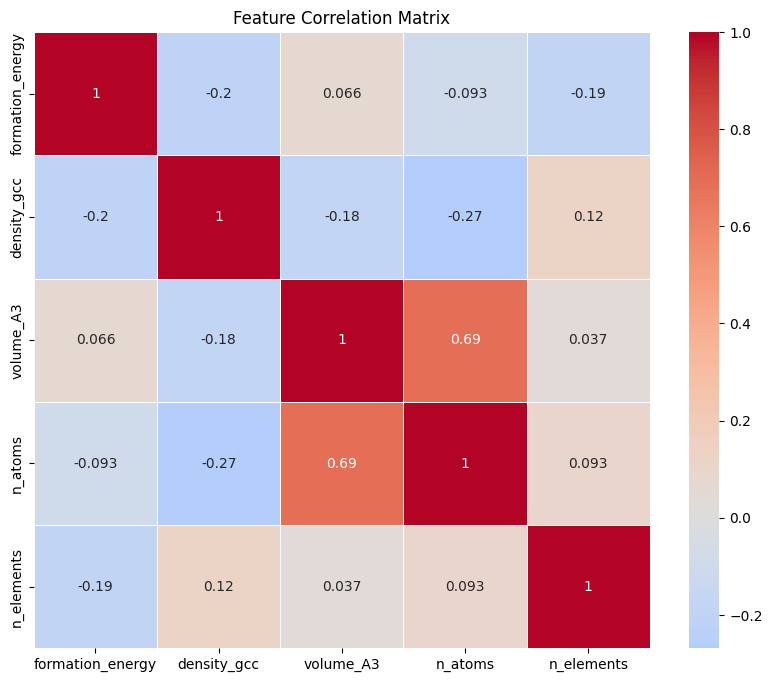

In [9]:
# Correlation Matrix
plt.figure(figsize=(10, 8))

# Automatically select numerical columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# Remove the target variable to analyze feature-only correlation
numeric_cols_for_corr = numeric_cols.drop('bandgap_eV')

# Calculate correlation matrix
correlation_matrix = train_df[numeric_cols_for_corr].corr()

# Visualize with a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

The correlation matrix highlights a strong positive relationship (0.69) between unit cell volume and the number of atoms, while other physical descriptors show minimal coupling.

# **2.3 Feature Engineering with Materials Informatics**

In [10]:
# Create a copy of train_df to avoid modifying the original training data
feature_df = train_df.copy()

# Convert strings to Composition objects
stc = StrToComposition(target_col_id='composition_obj')
# featurize_dataframe add 'composition_obj'
feature_df = stc.featurize_dataframe(feature_df, "composition")

print(f"Dataset shape after composition conversion: {feature_df.shape}")

# Selected key descriptors to balance model accuracy and computational complexity
featurizers = [
    cf.ElementProperty.from_preset("magpie"), # Elemental properties
    cf.Stoichiometry(),                      #  Stoichiometric features
    cf.ElementFraction(),                    # Element fraction features
    cf.TMetalFraction(),                     # Transition metal fraction
]

# Apply featurizers one by one
print("Applying featurizers...")

for i, featurizer in enumerate(featurizers):
    try:
        print(f"Applying featurizer {i+1}/{len(featurizers)}: {featurizer.__class__.__name__}")


        # Add features to dataframe, use ignore_errors=True to skip problematic entries
        feature_df = featurizer.featurize_dataframe(feature_df, col_id="composition_obj", ignore_errors=True)

        print(f"Shape after {featurizer.__class__.__name__}: {feature_df.shape}")
    except Exception as e:
        print(f"Error with featurizer {featurizer.__class__.__name__}: {e}")
        continue

print(f"Final dataset shape after featurization: {feature_df.shape}")


# Remove non-numeric columns like formula strings and composition objects
non_feature_cols = ['composition', 'pretty_formula', 'composition_obj', 'material_id', 'formula']
# Select columns with numerical data types
feature_cols = [col for col in feature_df.columns if col not in non_feature_cols]
numeric_features = feature_df[feature_cols].select_dtypes(include=[np.number])

print(f"Number of numeric features: {numeric_features.shape[1]}")

# Clean the dataset
# For missing values: fill them with median
numeric_features = numeric_features.replace([np.inf, -np.inf], np.nan)
numeric_features = numeric_features.fillna(numeric_features.median())

# Target y is the bandgap; feature matrix X includes all other numerical descriptors
y = numeric_features['bandgap_eV'].copy()
X = numeric_features.drop(['bandgap_eV'], axis=1)

print(f"Target variable shape: {y.shape}")
print(f"Feature matrix shape: {X.shape}")
# Show names of the first 10 descriptors
print(f"Sample features: {list(X.columns[:10])}")

StrToComposition:   0%|          | 0/2400 [00:00<?, ?it/s]

Dataset shape after composition conversion: (2400, 10)
Applying featurizers...
Applying featurizer 1/4: ElementProperty


ElementProperty:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after ElementProperty: (2400, 142)
Applying featurizer 2/4: Stoichiometry


Stoichiometry:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after Stoichiometry: (2400, 148)
Applying featurizer 3/4: ElementFraction


ElementFraction:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after ElementFraction: (2400, 266)
Applying featurizer 4/4: TMetalFraction


TMetalFraction:   0%|          | 0/2400 [00:00<?, ?it/s]

Shape after TMetalFraction: (2400, 267)
Final dataset shape after featurization: (2400, 267)
Number of numeric features: 263
Target variable shape: (2400,)
Feature matrix shape: (2400, 262)
Sample features: ['formation_energy', 'density_gcc', 'volume_A3', 'n_atoms', 'n_elements', 'MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number']


In [11]:
# Create a copy of the test dataframe to ensure the original raw data remains untouched
test_feature_df = test_df.copy()


# Use the StrToComposition (stc) featurizer to convert chemical formula strings
test_feature_df = stc.featurize_dataframe(test_feature_df, "composition")

print(f"Test dataset shape after composition conversion: {test_feature_df.shape}")

# Iteratively apply the same list of featurizers used for the training set.
print("Applying featurizers to test data...")

for i, featurizer in enumerate(featurizers):
    try:
        # Display progress and the name of the current featurizer class
        print(f"Applying featurizer {i+1}/{len(featurizers)}: {featurizer.__class__.__name__}")

        # Extract features based on the "composition_obj" column.
        test_feature_df = featurizer.featurize_dataframe(test_feature_df, col_id="composition_obj", ignore_errors=True)

        print(f"Shape after {featurizer.__class__.__name__}: {test_feature_df.shape}")
    except Exception as e:
        # Catch and report any catastrophic errors specific to a featurizer
        print(f"Error with featurizer {featurizer.__class__.__name__}: {e}")
        continue

print(f"Final test dataset shape after featurization: {test_feature_df.shape}")

# Extract only the columns that were defined during the training phase.
test_numeric_features = test_feature_df[feature_cols].select_dtypes(include=[np.number])

# Data Cleaning
test_numeric_features = test_numeric_features.replace([np.inf, -np.inf], np.nan)

# Fill missing values (NaN) using the median of the current column.
test_numeric_features = test_numeric_features.fillna(test_numeric_features.median())

# Extract the ground truth target variable ('bandgap_ev') for final evaluation.
y_test_true = test_numeric_features['bandgap_eV'].copy()
X_test_raw = test_numeric_features.drop(['bandgap_eV'], axis=1)

# Drop the target column from the feature matrix to prevent data leakage.
X_test_features = test_numeric_features.drop(['bandgap_eV'], axis=1)

print(f"Test target variable shape: {y_test_true.shape}")
print(f"Test feature matrix shape: {X_test_features.shape}")
print("Test data featurization complete")

StrToComposition:   0%|          | 0/600 [00:00<?, ?it/s]

Test dataset shape after composition conversion: (600, 10)
Applying featurizers to test data...
Applying featurizer 1/4: ElementProperty


ElementProperty:   0%|          | 0/600 [00:00<?, ?it/s]

Shape after ElementProperty: (600, 142)
Applying featurizer 2/4: Stoichiometry


Stoichiometry:   0%|          | 0/600 [00:00<?, ?it/s]

Shape after Stoichiometry: (600, 148)
Applying featurizer 3/4: ElementFraction


ElementFraction:   0%|          | 0/600 [00:00<?, ?it/s]

Shape after ElementFraction: (600, 266)
Applying featurizer 4/4: TMetalFraction


TMetalFraction:   0%|          | 0/600 [00:00<?, ?it/s]

Shape after TMetalFraction: (600, 267)
Final test dataset shape after featurization: (600, 267)
Test target variable shape: (600,)
Test feature matrix shape: (600, 262)
Test data featurization complete


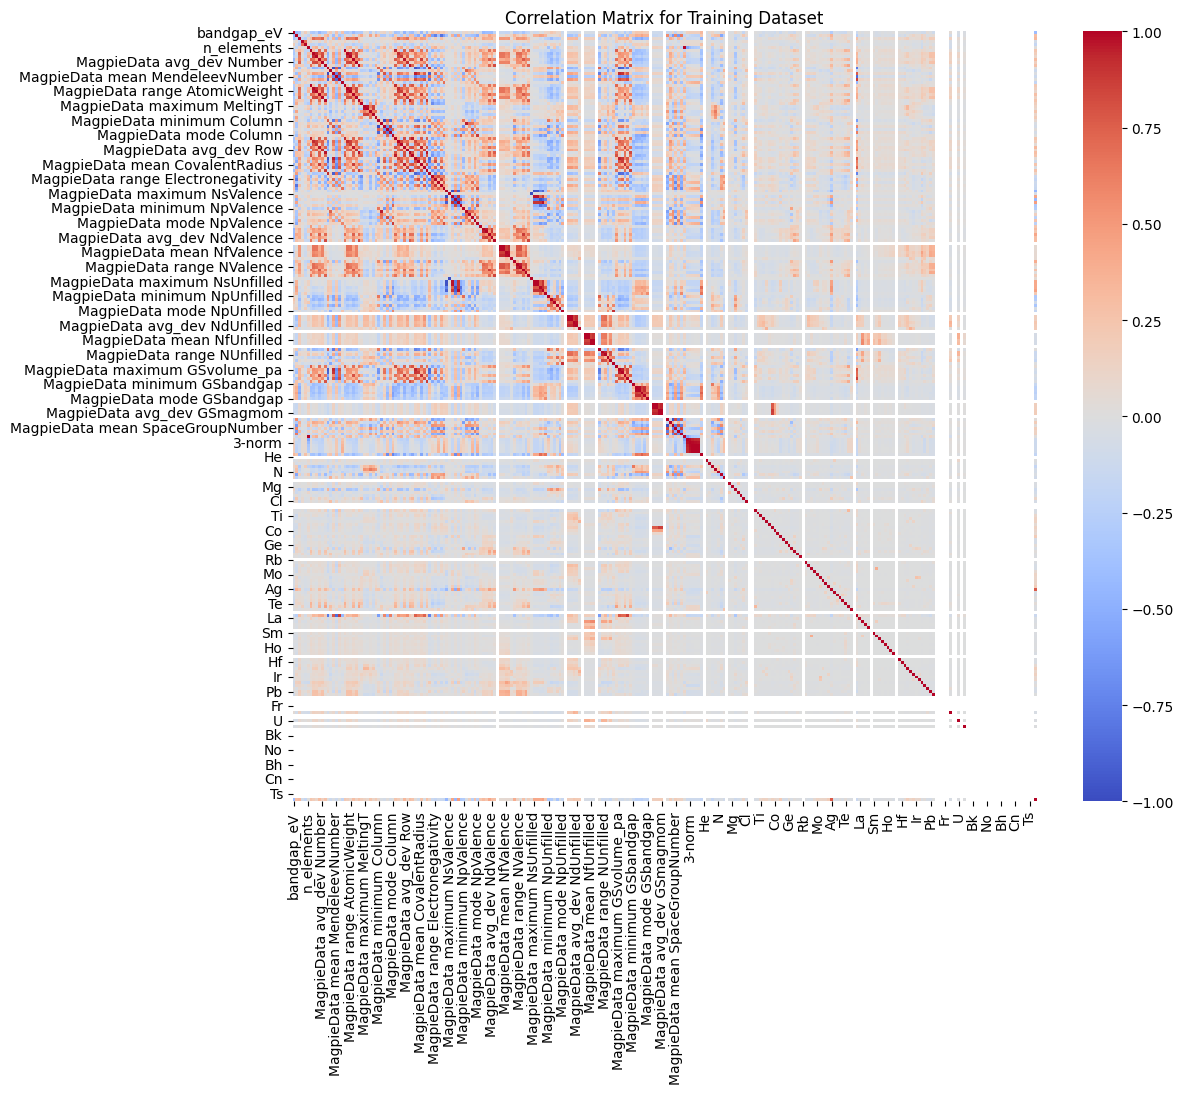

In [12]:
# Feature Correlation Matrix
plt.figure(figsize=(12, 10))
# Calculate correlation matrix
correlation_matrix = numeric_features.corr()

# Draw heatmap to check for multicollinearity between features
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Training Dataset')
plt.show()


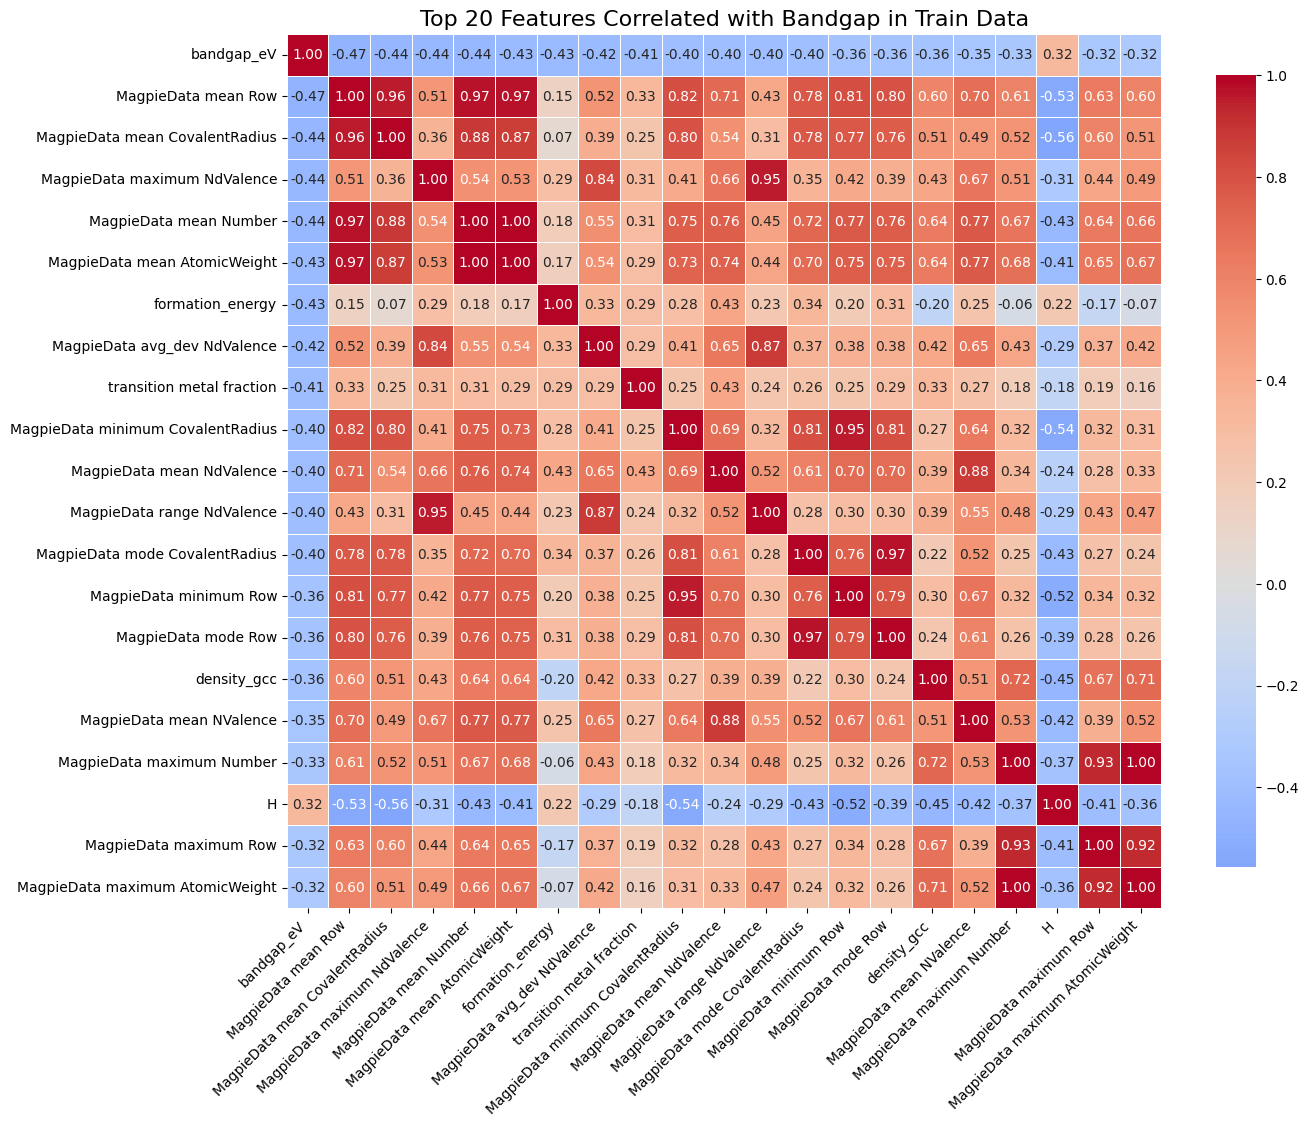


Highest correlations with bandgap_eV:
bandgap_eV                           1.000000
MagpieData mean Row                  0.467247
MagpieData mean CovalentRadius       0.442849
MagpieData maximum NdValence         0.439834
MagpieData mean Number               0.437690
MagpieData mean AtomicWeight         0.428347
formation_energy                     0.425263
MagpieData avg_dev NdValence         0.421553
transition metal fraction            0.406779
MagpieData minimum CovalentRadius    0.401145
Name: bandgap_eV, dtype: float64


In [13]:
# Identify the top 20 most correlated features
target_corr = numeric_features.corr()['bandgap_eV'].abs().sort_values(ascending=False)

# Select the top 20 features
top_20_features = target_corr.head(21).index

# Create the filtered correlation matrix
filtered_corr_matrix = numeric_features[top_20_features].corr()

# Plot the Heatmap
plt.figure(figsize=(14, 12))


sns.heatmap(
    filtered_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title('Top 20 Features Correlated with Bandgap in Train Data', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Highest correlations with bandgap
print("\nHighest correlations with bandgap_eV:")
# Sort features by absolute correlation with the target
bandgap_correlations = correlation_matrix['bandgap_eV'].abs().sort_values(ascending=False)
print(bandgap_correlations.head(10))

The features most strongly correlated with the bandgap are primarily centered on intrinsic atomic properties and electronic configurations. The data reveals that the periodic table position (Row, Atomic Number/Weight), atomic size (CovalentRadius), and descriptors related to valence electrons (NdValence) are the strongest predictors, with correlation coefficients typically between 0.4 and 0.5.

# **2.4 Dimensionality Reduction**

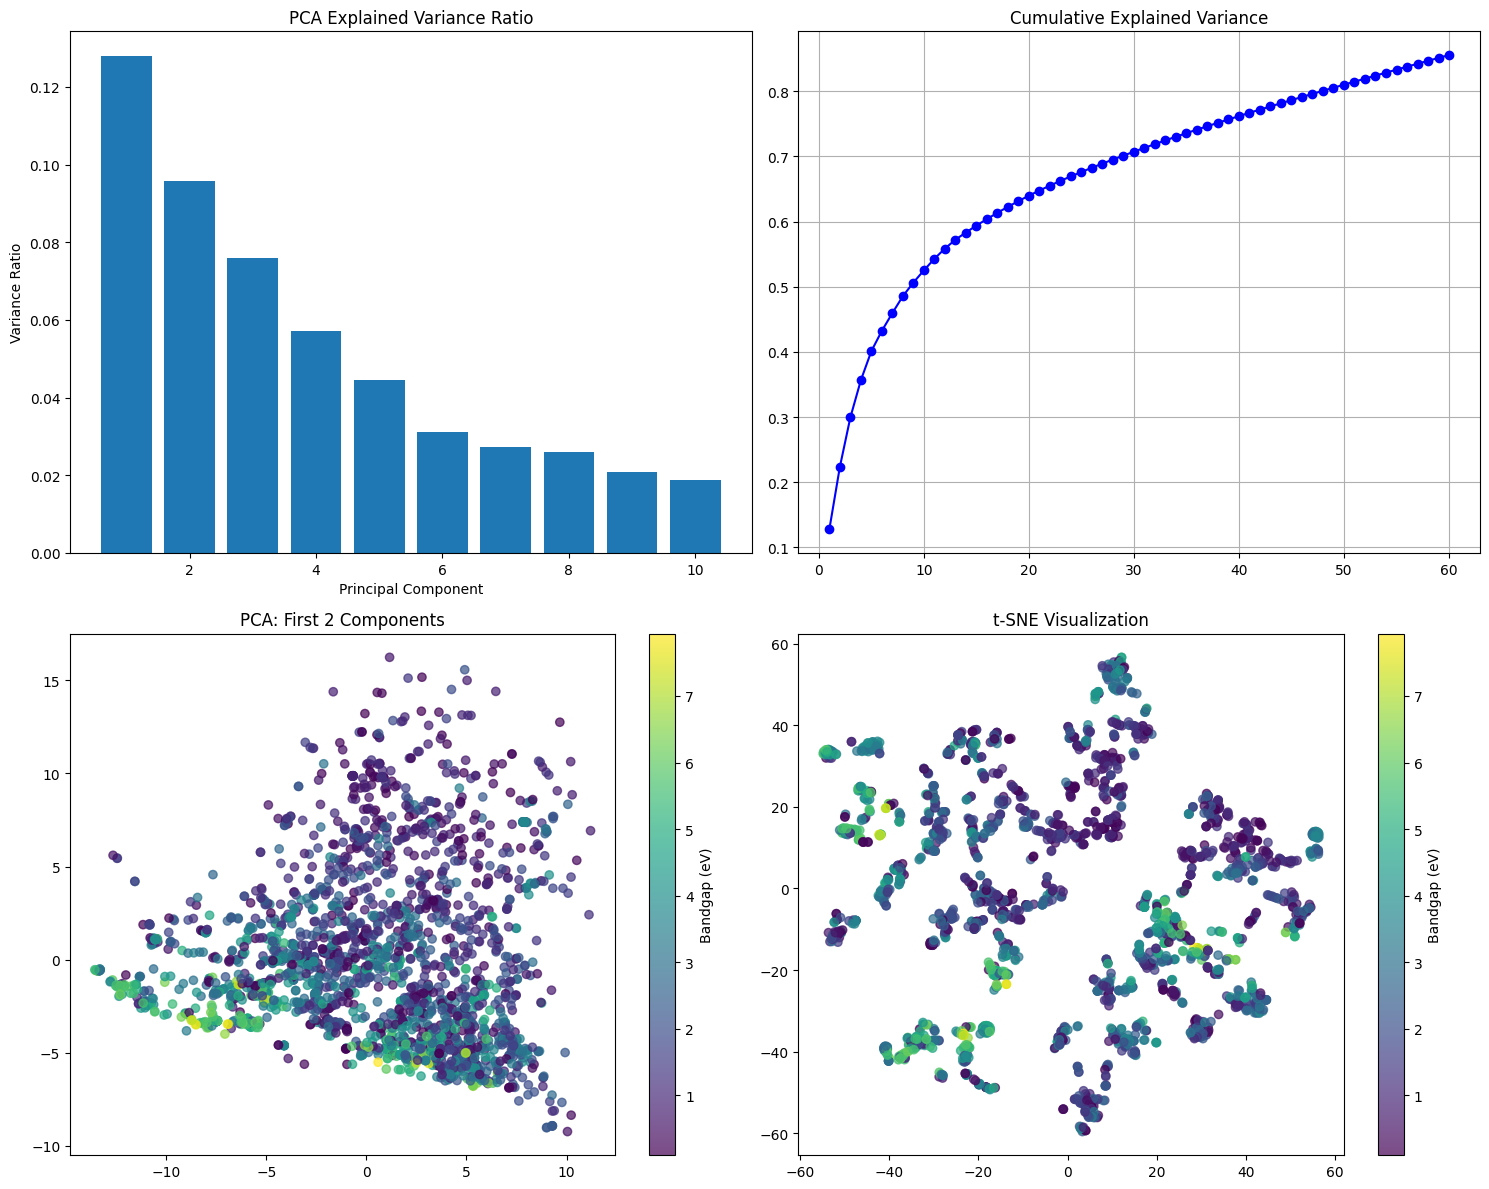


Using PCA-reduced features with 60 components for modeling


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Principal Component Analysis
n_components = min(60, X.shape[0]-1)
pca = PCA(n_components=n_components, random_state=1003)
X_pca = pca.fit_transform(X_scaled)

# t-SNE for Visualization
if X.shape[0] > 30:
    tsne = TSNE(n_components=2, random_state=1003, perplexity=min(30, X.shape[0]//3))
    X_tsne = tsne.fit_transform(X_pca[:, :min(10, n_components)])
else:
    X_tsne = None

# Visualizing Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Bar plot for individual explained variance
axes[0,0].bar(range(1, len(pca.explained_variance_ratio_[:10])+1), pca.explained_variance_ratio_[:10])
axes[0,0].set_title('PCA Explained Variance Ratio')
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Ratio')

# Cumulative explained variance plot
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
axes[0,1].plot(range(1, len(cumsum_var)+1), cumsum_var, 'bo-')
axes[0,1].set_title('Cumulative Explained Variance')
axes[0,1].grid(True)

# PCA scatter plot colored by Bandgap
scatter = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1,0].set_title('PCA: First 2 Components')
plt.colorbar(scatter, ax=axes[1,0], label='Bandgap (eV)')

# plot t-SNE
if X_tsne is not None:
    scatter2 = axes[1,1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[1,1].set_title('t-SNE Visualization')
    plt.colorbar(scatter2, ax=axes[1,1], label='Bandgap (eV)')

plt.tight_layout()
plt.show()

# Use PCA features for further analysis ---
X_reduced = X_pca
print(f"\nUsing PCA-reduced features with {X_reduced.shape[1]} components for modeling")

The PCA results indicate that the first two principal components account for only about 23% of the variance, with approximately 60 components required to reach an 85% cumulative explained variance ratio. The t-SNE visualization reveals more distinct local clusters; crucially, both methods demonstrate that bandgap values cluster systematically within the feature space rather than appearing at random. It confirms that the selected descriptors effectively capture the underlying physics governing the electronic properties

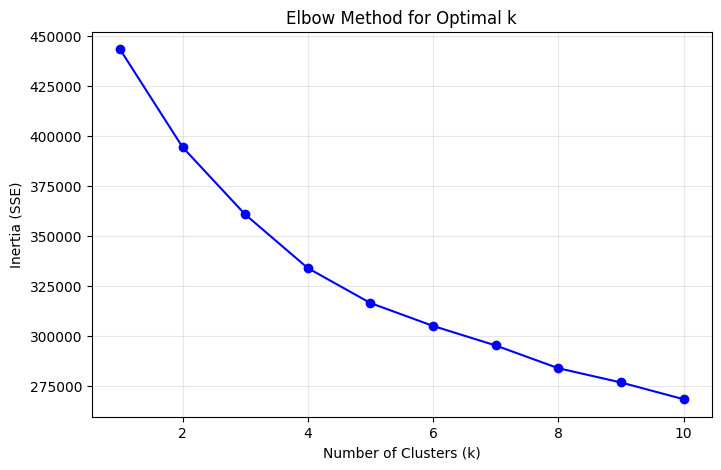

In [15]:
from sklearn.cluster import KMeans

# Determining Optimal num_clusters using the Elbow Method
# test k values from 1 to 10
inertia = []
k_range = range(1, 11)

for k in k_range:
    # Use the same random_state for consistency across tests
    km = KMeans(n_clusters=k, random_state=1003, n_init=10)
    km.fit(X_reduced)
    inertia.append(km.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.grid(True, alpha=0.3)
plt.show()

Based on the Elbow Method analysis, the inertia decreases sharply until k=4 and begins to plateau after k=5. Therefore, k=4 was selected as the optimal number of clusters.

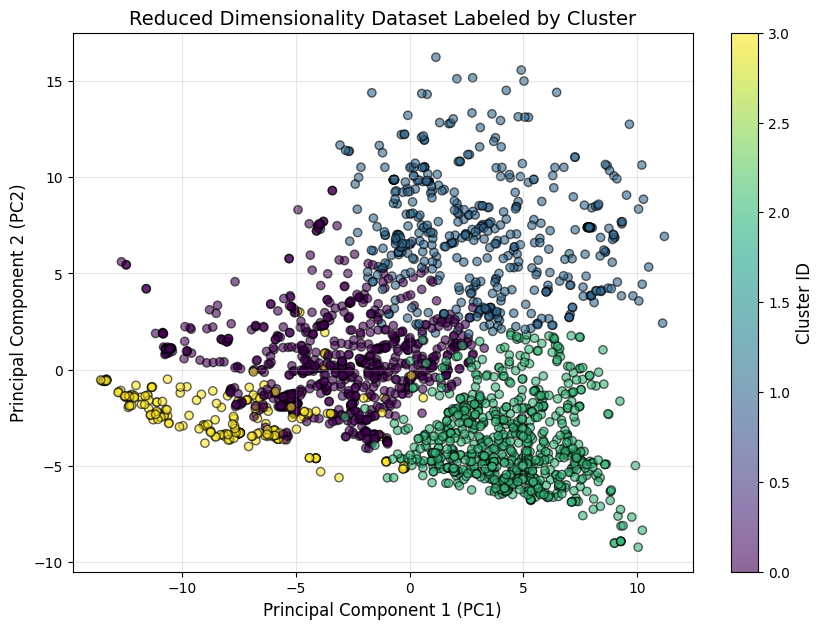

In [16]:
# K-Means Clustering on PCA-Reduced Data
num_clusters = 4 # based on the elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=1003, n_init=10)
cluster_labels = kmeans.fit_predict(X_reduced)

# Plot the first two Principal Components colored by Cluster ID
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='k')

# Add a color bar to indicate Cluster ID as required by the assignment
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID', fontsize=12)

plt.title('Reduced Dimensionality Dataset Labeled by Cluster', fontsize=14)
plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

The clustering plot demonstrates that the algorithm successfully partitioned the dataset into four distinct groups based on their principal component scores, revealing a natural organization of materials within the feature space. Cluster 3 (yellow) is tightly concentrated at low PC1 and PC2 values, whereas Cluster 1 (blue) and Cluster 2 (green) are more widely dispersed across the positive PC1 range.

# **2.5 Feature Selection**

Searching for the optimal k value...
Optimal k determined: 22


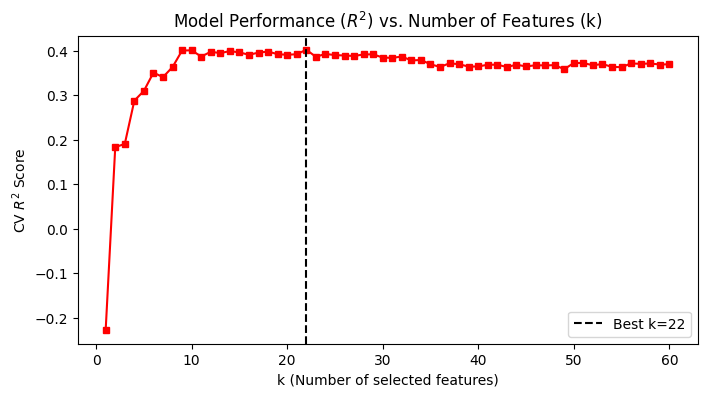

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
# Optimizing k via CV
print("Searching for the optimal k value...")
k_values = range(1, 61)
cv_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_tmp = selector.fit_transform(X_reduced, y)

    # CV for accuracy
    model = RandomForestRegressor(n_estimators=50, random_state=1003, n_jobs=-1)
    scores = cross_val_score(model, X_tmp, y, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k determined: {optimal_k}")

# Plot k-optimization curve
plt.figure(figsize=(8, 4))
plt.plot(k_values, cv_scores, 'rs-', markersize=4)
plt.axvline(x=optimal_k, color='k', linestyle='--', label=f'Best k={optimal_k}')
plt.title('Model Performance ($R^2$) vs. Number of Features (k)')
plt.xlabel('k (Number of selected features)')
plt.ylabel('CV $R^2$ Score')
plt.legend()
plt.show()

Original PCA features: 60
Selected features: 22
Feature scores for PCA components (top 22):
PC1: 234.29
PC2: 379.05
PC3: 19.37
PC5: 96.67
PC6: 25.63
PC7: 109.71
PC8: 40.43
PC11: 165.25
PC13: 29.63
PC15: 5.69
PC16: 4.73
PC17: 5.63
PC18: 4.64
PC25: 10.59
PC27: 11.57
PC28: 8.79
PC29: 5.66
PC36: 3.69
PC41: 6.10
PC44: 3.31
PC47: 2.92
PC48: 18.64


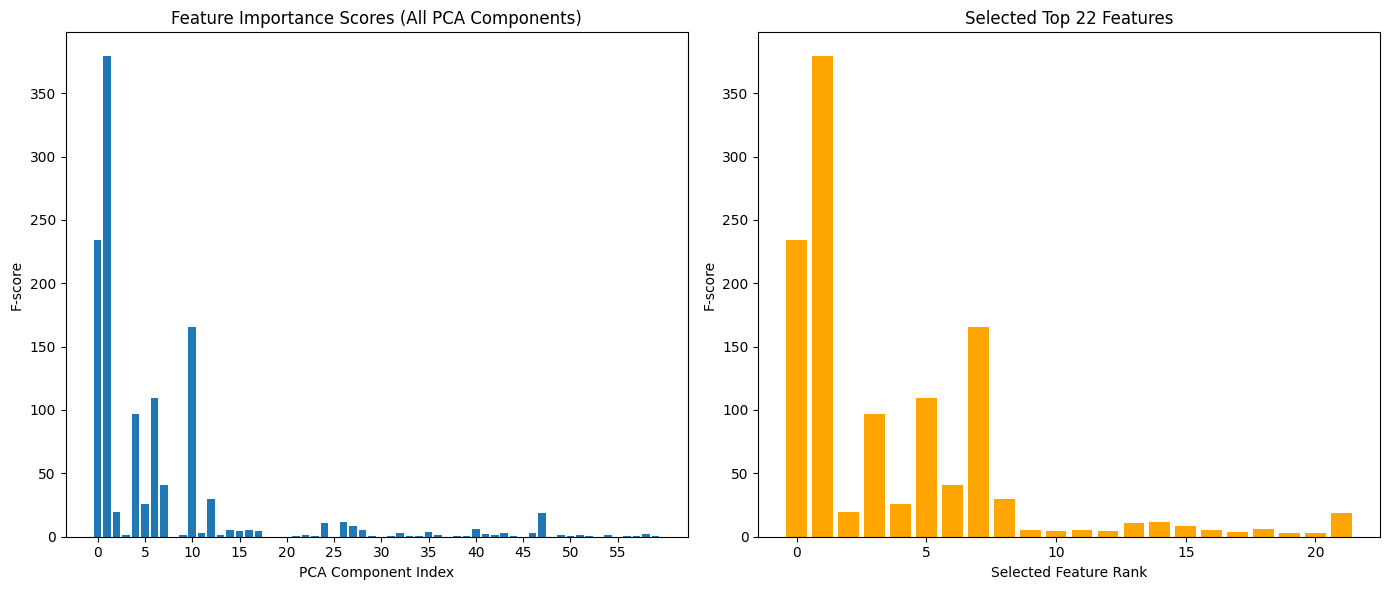


Final feature matrix shape: (2400, 22)


In [19]:
from sklearn.feature_selection import SelectKBest, f_regression

# k=22 yields the best R² performance.
optimal_k = 22
# Ensure k does not exceed the total number of features.
k_best = min(optimal_k, X_reduced.shape[1])

# Initialize SelectKBest using f_regression as the scoring function.
selector = SelectKBest(score_func=f_regression, k=k_best)

# Fit the selector to X_reduced and transform. All 2400 samples are kept.
X_selected = selector.fit_transform(X_reduced, y)

print(f"Original PCA features: {X_reduced.shape[1]}")
print(f"Selected features: {X_selected.shape[1]}")


# Retrieve raw F-scores for all PCA components.
feature_scores = selector.scores_

# Get a boolean mask for the selected features.
selected_features = selector.get_support()

print(f"Feature scores for PCA components (top {k_best}):")

# Get the actual indices of the selected features.
selected_indices = np.where(selected_features)[0]


# Loop through and print selected PC indices and their scores.
for i, (idx, score) in enumerate(zip(selected_indices, feature_scores[selected_features])):

    # Use idx+1 to make PC numbering more intuitive.
    print(f"PC{idx+1}: {score:.2f}")

# Visualize Feature Importance
plt.figure(figsize=(14, 6))

# Comparing scores of all PCA components
plt.subplot(1, 2, 1)
plt.bar(range(len(feature_scores)), feature_scores)
plt.title('Feature Importance Scores (All PCA Components)')
plt.xlabel('PCA Component Index')
plt.ylabel('F-score')
plt.xticks(range(0, len(feature_scores), 5))


# Visualizing the top 22 selected features
plt.subplot(1, 2, 2)
selected_scores = feature_scores[selected_features]
plt.bar(range(len(selected_scores)), selected_scores, color='orange')
plt.title(f'Selected Top {k_best} Features')
plt.xlabel('Selected Feature Rank')
plt.ylabel('F-score')

plt.tight_layout()
plt.show()

print(f"\nFinal feature matrix shape: {X_selected.shape}")

I utilized the SelectKBest algorithm from Scikit-Learn, which ranks features based on their statistical significance. The f_regression function was chosen as the scoring metric. It computes the F-statistic to evaluate the linear correlation between each chemical descriptor and the Bandgap.By identifying the top 22 features, I effectively reduced the dimensionality of the input space. This balance ensures high predictive accuracy while preventing the model from over-fitting to irrelevant features.

# **2.6 Cross-Validation Strategy and Model Training**

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=1003
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_val.shape}")

# Define Random Forest Regressor with hyperparameter tuning
rf_regressor = RandomForestRegressor(random_state=1003)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter optimization
cv_folds = min(5, len(X_train) // 3)
print(f"Using {cv_folds}-fold cross-validation")

grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
print("Training Random Forest Regressor with Grid Search...")
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {-grid_search.best_score_:.4f}")

# Make predictions
y_train_pred = best_rf.predict(X_train)
y_val_pred = best_rf.predict(X_val)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\nModel Performance:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Feature importance from the best model
feature_importance = best_rf.feature_importances_
print("\nFeature Importance (Selected PCA Components):")
for i, importance in enumerate(feature_importance):
    print(f"Feature {i+1}: {importance:.4f}")

Training set size: (1920, 22)
Testing set size: (480, 22)
Using 5-fold cross-validation
Training Random Forest Regressor with Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 1.0967

Model Performance:
Training MSE: 0.1531
Validation MSE: 0.8821
Training MAE: 0.2805
Validation MAE: 0.6637
Training R²: 0.9471
Validation R²: 0.6698

Feature Importance (Selected PCA Components):
Feature 1: 0.1933
Feature 2: 0.1781
Feature 3: 0.0732
Feature 4: 0.0463
Feature 5: 0.0567
Feature 6: 0.0529
Feature 7: 0.0311
Feature 8: 0.0407
Feature 9: 0.0344
Feature 10: 0.0253
Feature 11: 0.0232
Feature 12: 0.0178
Feature 13: 0.0206
Feature 14: 0.0208
Feature 15: 0.0224
Feature 16: 0.0187
Feature 17: 0.0226
Feature 18: 0.0216
Feature 19: 0.0268
Feature 20: 0.0257
Feature 21: 0.0264
Feature 22: 0.0214


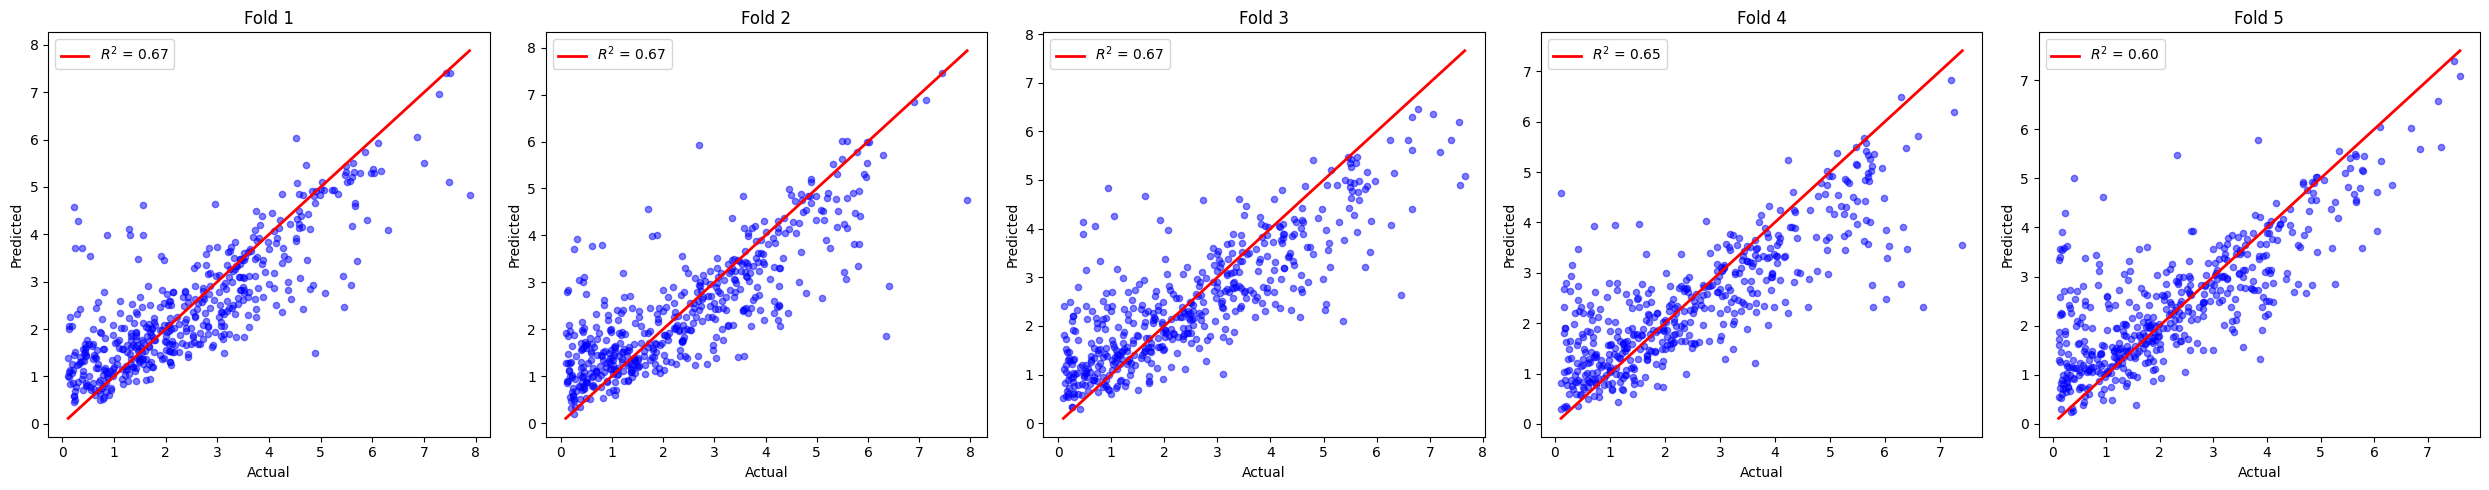

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# Visualizing 5-Fold Cross-Validation Parity Plots
kf = KFold(n_splits=5, shuffle=True, random_state=1003)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

y_np = y.values if hasattr(y, 'values') else y

for i, (train_index, val_index) in enumerate(kf.split(X_selected)):
    X_train_fold, X_val_fold = X_selected[train_index], X_selected[val_index]
    y_train_fold, y_val_fold = y_np[train_index], y_np[val_index]

    # Train model
    best_rf.fit(X_train_fold, y_train_fold)

    # Predict
    y_pred_fold = best_rf.predict(X_val_fold)
    fold_r2 = r2_score(y_val_fold, y_pred_fold)

    # Plotting
    ax = axes[i]
    ax.scatter(y_val_fold, y_pred_fold, color='blue', alpha=0.5, s=20)

    # Diagonal line
    all_vals = np.concatenate([y_val_fold, y_pred_fold])
    min_v, max_v = all_vals.min(), all_vals.max()
    ax.plot([min_v, max_v], [min_v, max_v], 'r-', lw=2, label=f'$R^2$ = {fold_r2:.2f}')

    ax.set_title(f'Fold {i+1}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

The 5-fold cross-validation results indicate that the model possesses robust predictive power across different data subsets, with R2 scores ranging from 0.60 to 0.67. In the scatter plots, the predicted values are closely distributed around the y=x reference line, demonstrating that the model has successfully captured the underlying physical relationship between descriptors and the bandgap. It validates the model's generalization capability.

# **2.7 Results Visualization and Analysis**

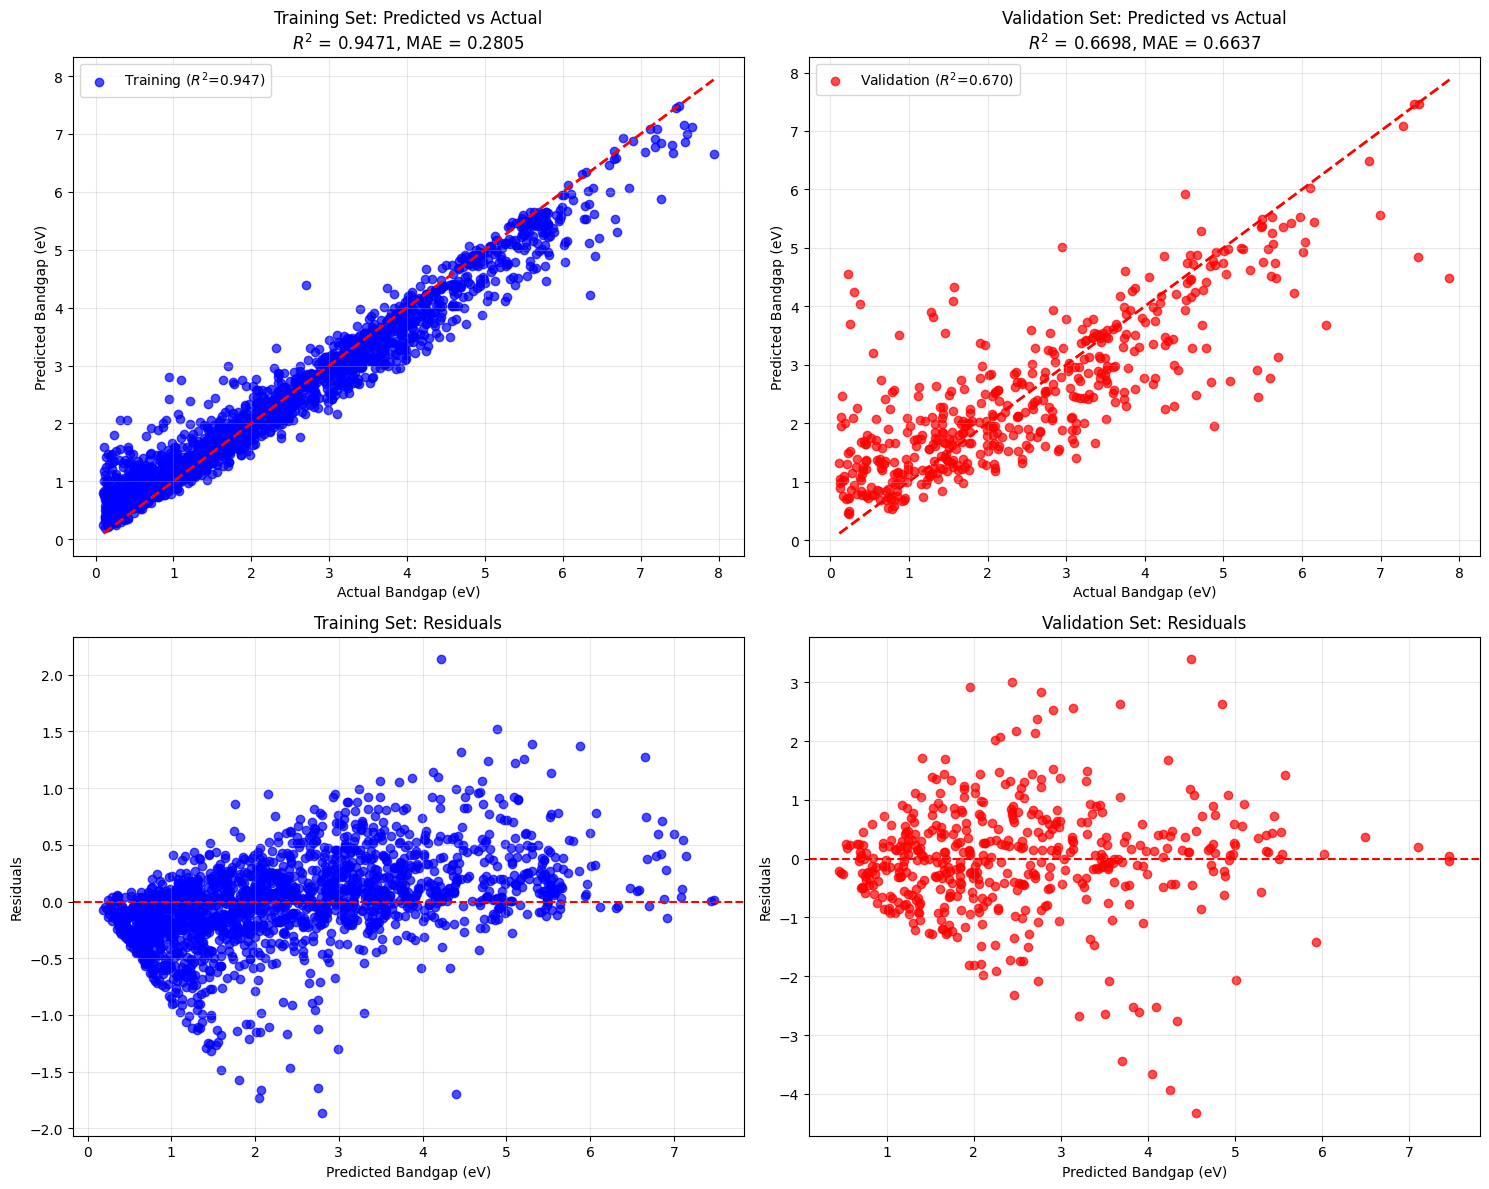

In [22]:
# Plot Predicted vs Actual & Residuals ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#  Training Predicted vs Actual
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.7, color='blue', label=f'Training ($R^2$={train_r2:.3f})')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_title(f'Training Set: Predicted vs Actual\n$R^2$ = {train_r2:.4f}, MAE = {train_mae:.4f}')
axes[0, 0].set_xlabel('Actual Bandgap (eV)')
axes[0, 0].set_ylabel('Predicted Bandgap (eV)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Predicted vs Actual
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.7, color='red', label=f'Validation ($R^2$={val_r2:.3f})')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_title(f'Validation Set: Predicted vs Actual\n$R^2$ = {val_r2:.4f}, MAE = {val_mae:.4f}')
axes[0, 1].set_xlabel('Actual Bandgap (eV)')
axes[0, 1].set_ylabel('Predicted Bandgap (eV)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3 (Left): Training Residuals
# Residuals = Actual - Predicted
axes[1, 0].scatter(y_train_pred, y_train - y_train_pred, alpha=0.7, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('Training Set: Residuals')
axes[1, 0].set_xlabel('Predicted Bandgap (eV)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Validation Residuals
axes[1, 1].scatter(y_val_pred, y_val - y_val_pred, alpha=0.7, color='red')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Validation Set: Residuals')
axes[1, 1].set_xlabel('Predicted Bandgap (eV)')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The final model assessment reveals exceptional accuracy on the training set (R2 = 0.947, MAE = 0.2805 eV), while the validation set maintains a solid R2 of 0.6698 (MAE = 0.6631 eV), confirming the model’s ability to generalize effectively without significant overfitting. Residual plots indicate that while most errors are centered around the zero-line, there is increased variance in the low-bandgap region (< 2 eV) and a few notable outliers in the 3-5 eV range of the validation set.

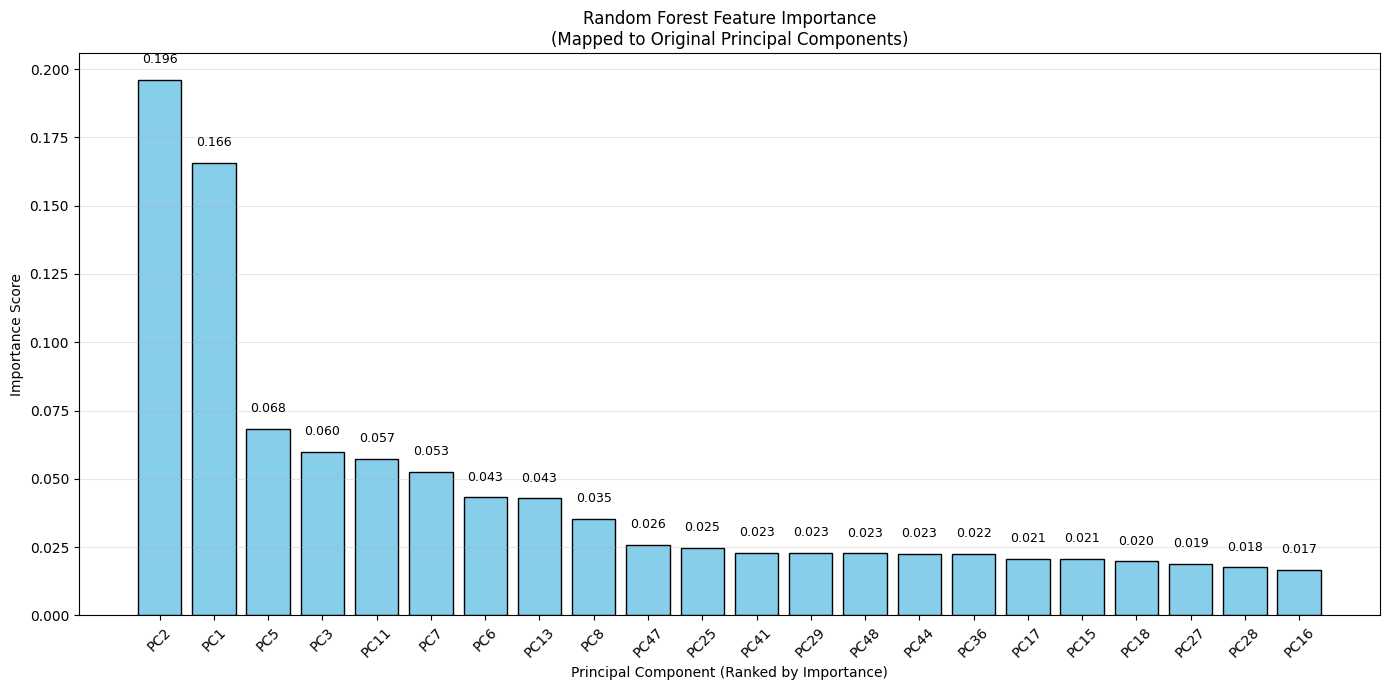

Top 5 Contributing Principal Components:
PC2: 0.1960
PC1: 0.1656
PC5: 0.0683
PC3: 0.0598
PC11: 0.0574


In [23]:
# Get the actual indices of the selected features from the original 60 PCs
selected_indices = selector.get_support(indices=True)

# Create specific PC label names (e.g., PC1, PC2, PC5...)
pc_names = [f"PC{i+1}" for i in selected_indices]

# Get and Sort Importance Scores
importances = best_rf.feature_importances_

# Sort for better visualization
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_pc_names = [pc_names[i] for i in sorted_idx]

# Plot Updated Feature Importance
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(sorted_importances)), sorted_importances, color='skyblue', edgecolor='black')

# Replace x-axis with actual Principal Component names
plt.xticks(range(len(sorted_importances)), sorted_pc_names, rotation=45)

plt.title(f'Random Forest Feature Importance\n(Mapped to Original Principal Components)')
plt.xlabel('Principal Component (Ranked by Importance)')
plt.ylabel('Importance Score')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 5 Contributing Principal Components:")
for i in range(5):
    print(f"{sorted_pc_names[i]}: {sorted_importances[i]:.4f}")

The feature importance chart reveals that the Random Forest model primarily relies on the core components derived from PCA, with PC1 (0.1960) and PC2 (0.1656) standing out as the most influential descriptors. Although the importance scores decrease rapidly, PC5, PC3, and others indicate that bandgap prediction is driven by a complex interplay of multiple physical factors.

# **2.8 Final Hold-out Test Evaluation**

--- Final Hold-out Test Performance (600 samples) ---
Final R² Score: 0.6898
Final MAE: 0.6698 eV
Final RMSE: 0.9409 eV


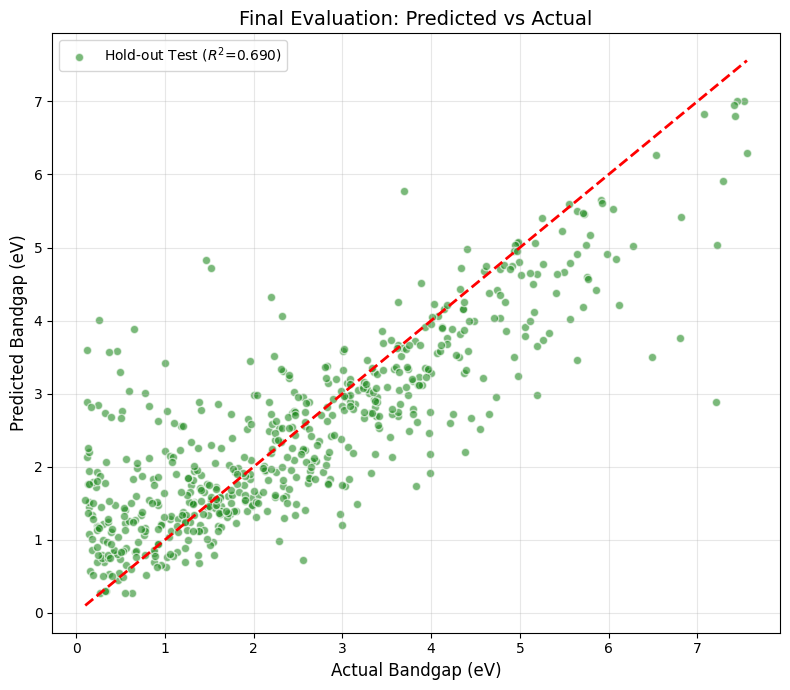

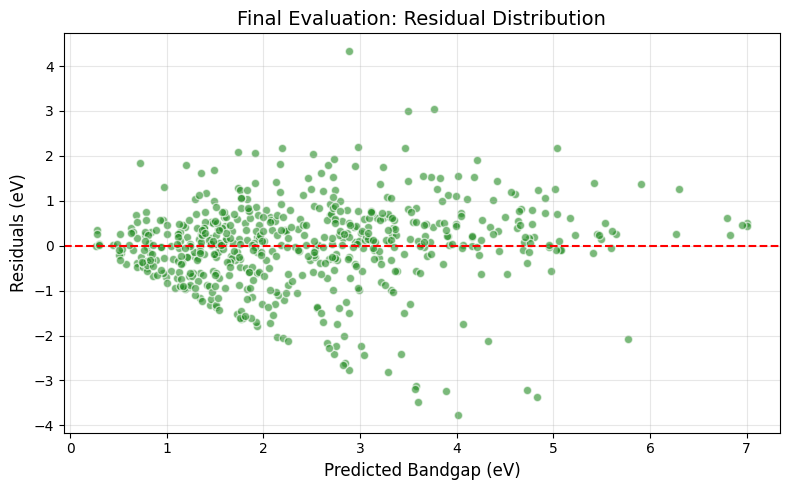

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Use objects fitted on training data to transform test data
X_test_scaled = scaler.transform(X_test_raw)
X_test_pca = pca.transform(X_test_scaled)
X_test_selected = selector.transform(X_test_pca)

# Final Prediction
y_test_pred = best_rf.predict(X_test_selected)

# Calculate Final Metrics
test_r2 = r2_score(y_test_true, y_test_pred)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

print(f"--- Final Hold-out Test Performance (600 samples) ---")
print(f"Final R² Score: {test_r2:.4f}")
print(f"Final MAE: {test_mae:.4f} eV")
print(f"Final RMSE: {test_rmse:.4f} eV")

# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 7))
plt.scatter(y_test_true, y_test_pred, alpha=0.6, color='forestgreen', edgecolors='w', label=f'Hold-out Test ($R^2$={test_r2:.3f})')

# Plot 45-degree reference line
min_val = min(y_test_true.min(), y_test_pred.min())
max_val = max(y_test_true.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.title(f'Final Evaluation: Predicted vs Actual', fontsize=14)
plt.xlabel('Actual Bandgap (eV)', fontsize=12)
plt.ylabel('Predicted Bandgap (eV)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Final Residuals
plt.figure(figsize=(8, 5))
residuals = y_test_true - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, color='forestgreen', edgecolors='w')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Final Evaluation: Residual Distribution', fontsize=14)
plt.xlabel('Predicted Bandgap (eV)', fontsize=12)
plt.ylabel('Residuals (eV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

These two plots present the final evaluation of the model on 600 completely independent external samples. The results highlight the model's good generalization capability, with a test R2 of 0.690, which is highly consistent with the earlier validation performance, proving the model's stability on unseen data. In the scatter plot, the predicted values closely track the actual values with a MAE of 0.6698 eV. The residual distribution shows that errors are symmetrically centered around the zero-line without significant systematic bias.

# **2.9 Analysis of Minimum Training Samples**

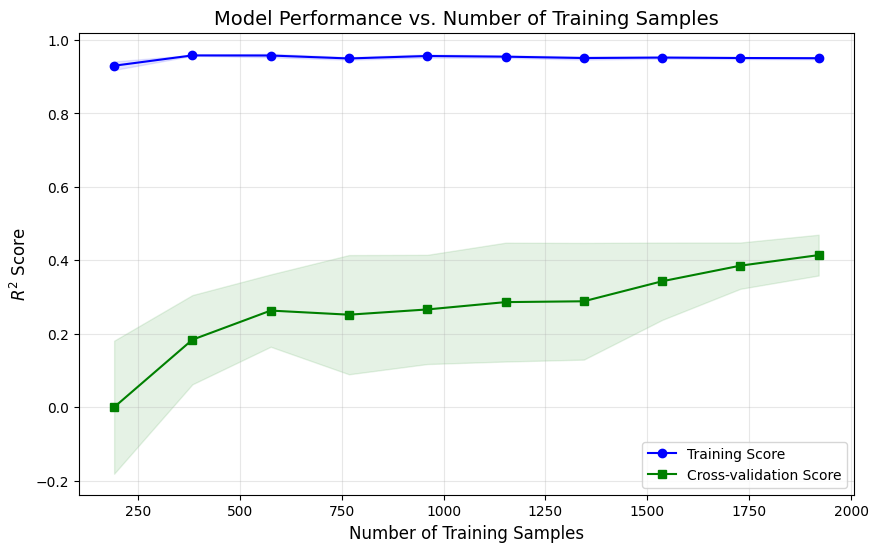

In [25]:
from sklearn.model_selection import learning_curve

# Learning Curve Analysis
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_selected, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2', n_jobs=-1
)

# Calculate mean and standard deviation for the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, val_mean, 's-', color="green", label="Cross-validation Score")

# Fill the area between the standard deviations to show variance
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

plt.title('Model Performance vs. Number of Training Samples', fontsize=14)
plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('$R^2$ Score', fontsize=12)
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.show()

Mathematical Plateau reached at: 576 samples


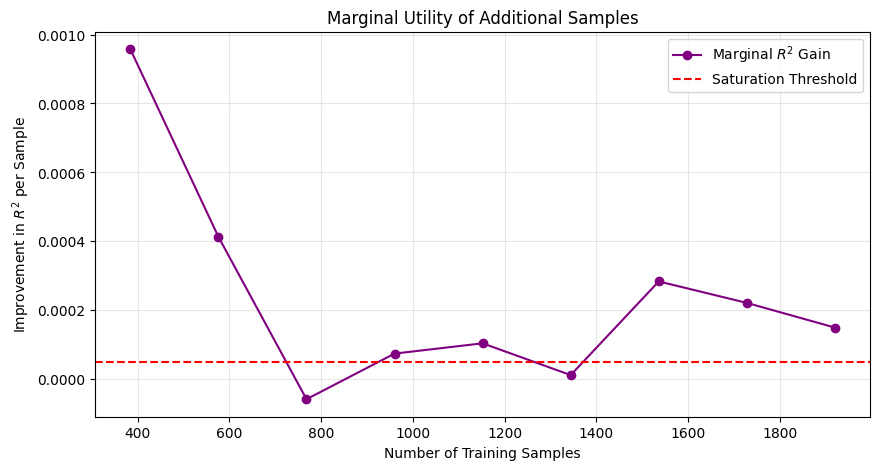

In [26]:
# Advanced Method: Marginal Gain Analysis
# Calculate the derivative of the Cross-validation score to find the plateau

# Calculate the improvement (delta) between each step
cv_mean = np.mean(val_scores, axis=1)
marginal_gains = np.diff(cv_mean) / np.diff(train_sizes)

# Define a threshold for saturation
threshold = 0.00005
plateau_index = np.where(marginal_gains < threshold)[0]

if len(plateau_index) > 0:
    min_samples = train_sizes[plateau_index[0]]
    print(f"Mathematical Plateau reached at: {int(min_samples)} samples")
else:
    min_samples = train_sizes[-1]
    print("Model has not fully plateaued yet.")

# Visualization of Marginal Gains
plt.figure(figsize=(10, 5))
plt.plot(train_sizes[1:], marginal_gains, 'o-', color='purple', label='Marginal $R^2$ Gain')
plt.axhline(y=threshold, color='r', linestyle='--', label='Saturation Threshold')
plt.title('Marginal Utility of Additional Samples')
plt.xlabel('Number of Training Samples')
plt.ylabel('Improvement in $R^2$ per Sample')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The learning curve illustrates that as the number of training samples grows, the cross-validation R^2 score rises steadily, while the training score remains consistently high at approximately 0.95, suggesting that additional data helps improve generalization despite persistent overfitting. To identify the minimum required dataset size, a marginal utility analysis was performed. A transient dip in marginal gain occurs around 800 samples, causing the mathematical plateau to be triggered prematurely at 576 samples.

# **2.10 Interpreting PC Physical Meanings**

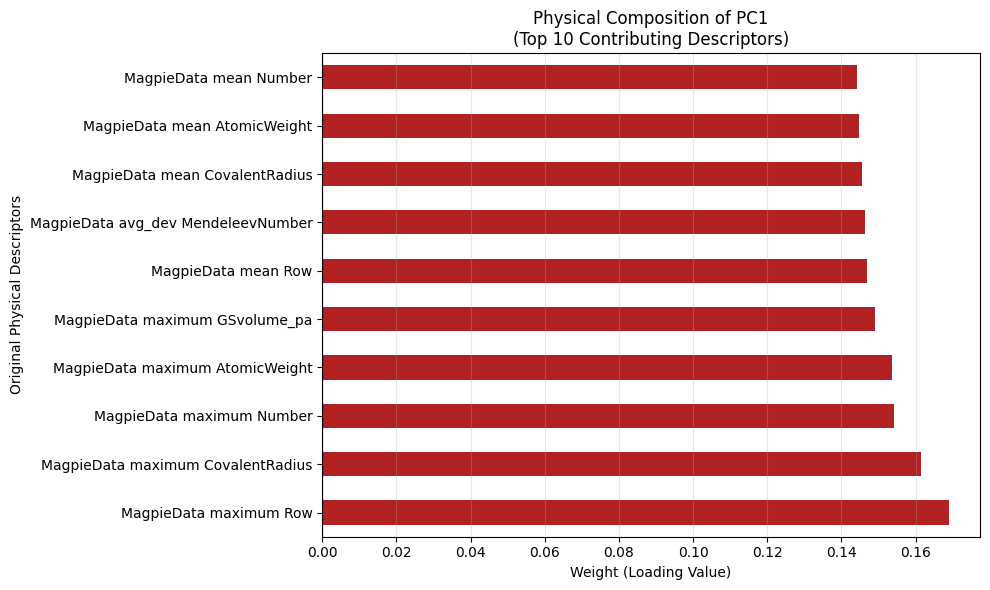

--- Top 5 Features for PC1 ---
MagpieData maximum Row               0.168924
MagpieData maximum CovalentRadius    0.161363
MagpieData maximum Number            0.154300
MagpieData maximum AtomicWeight      0.153691
MagpieData maximum GSvolume_pa       0.149130
Name: PC1, dtype: float64




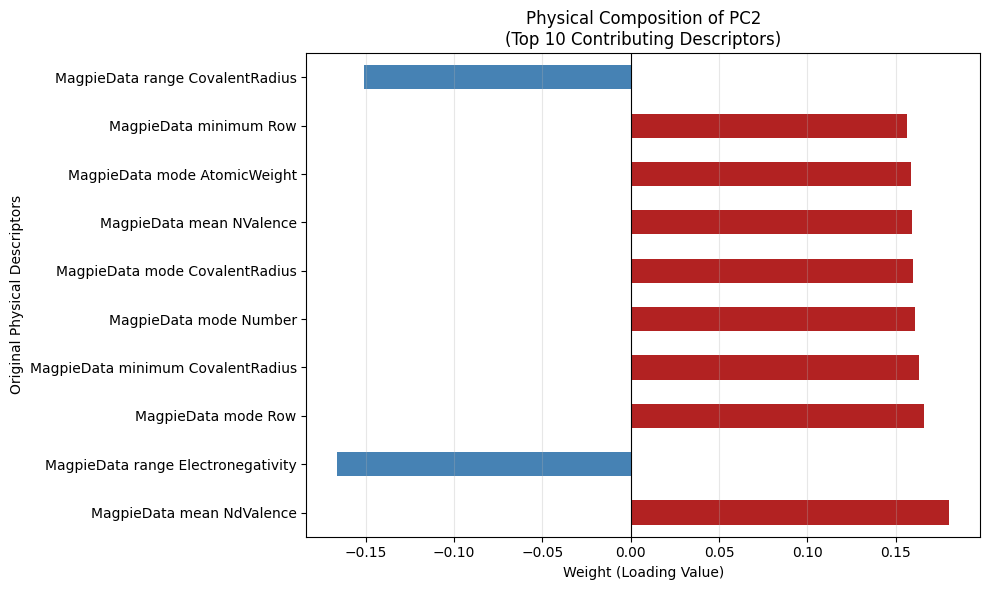

--- Top 5 Features for PC2 ---
MagpieData mean NdValence             0.180503
MagpieData range Electronegativity   -0.166301
MagpieData mode Row                   0.166143
MagpieData minimum CovalentRadius     0.163438
MagpieData mode Number                0.161263
Name: PC2, dtype: float64




In [27]:
# Prepare Loading Data
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X_test_raw.columns  # Use original feature names
)

# Define Analysis Function
def plot_pc_composition(pc_name, top_n=10):

    pc_loadings = loadings[pc_name].sort_values(key=abs, ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    colors = ['firebrick' if x > 0 else 'steelblue' for x in pc_loadings]
    pc_loadings.plot(kind='barh', color=colors)

    plt.title(f'Physical Composition of {pc_name}\n(Top {top_n} Contributing Descriptors)')
    plt.xlabel('Weight (Loading Value)')
    plt.ylabel('Original Physical Descriptors')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"--- Top 5 Features for {pc_name} ---")
    print(pc_loadings.head(5))
    print("\n")

# Based on Random Forest, PC1 and PC2 are the most critical
top_important_pcs = ['PC1', 'PC2']

for pc in top_important_pcs:
    plot_pc_composition(pc)

The feature importance results show that PC1 and PC2 are the most critical factors for predicting the bandgap. PC1 is primarily defined by atomic size and periodic position, specifically descriptors like MagpieData maximum Row and MagpieData maximum CovalentRadius. PC2 focuses on electronic characteristics, with MagpieData mean NdValence being the top contributor. Overall, atomic radius and d-orbital valence electrons emerge as the most important features. This is because these properties directly dictate the energy required for electron excitation, which defines the material's bandgap value.

# **3 Summary**

The analysis concludes that the machine learning model successfully captures the relationship between atomic descriptors and electronic properties, achieving a consistent test R2 of 0.69. Key insights reveal that atomic size (CovalentRadius) and electronic configuration (valence electrons) are the important factors governing the bandgap. While PCA effectively compressed the high-dimensional feature space, the learning curve analysis suggests that performance gains from simply increasing the dataset size plateaued at approximately 960 samples. Future work should focus on hyperparameter optimization or incorporating more complex structural descriptors to further reduce the residual errors.